In [1]:
import networkx as nx
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm
from itertools import combinations
from collections import defaultdict, deque
import math, random
import heapq
import scipy.sparse as sp
from collections import deque
from joblib import Parallel, delayed
from numba import njit
from typing import Tuple, Dict, List, Set, Sequence, Union
import itertools
import torch_geometric

In [12]:
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np

# 1. Build ER graph with p=0.045 and assign edge‐probabilities
n, p = 100, 0.045
G = nx.erdos_renyi_graph(n, p, seed=42)
for u, v in G.edges():
    G[u][v]['p'] = 0.8

In [13]:
# 2. Build PyG Data with only edge_weight
# edge_index: 2×|E| tensor (duplicate for undirected)
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

In [14]:
edge_index

tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,
          5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9, 10, 10,
         10, 10, 10, 10, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 15,
         15, 15, 15, 15, 15, 16, 16, 17, 17, 18, 19, 19, 19, 20, 20, 21, 21, 22,
         22, 22, 22, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 27, 27, 27,
         27, 28, 28, 28, 29, 30, 30, 30, 30, 31, 31, 32, 32, 32, 33, 33, 34, 34,
         34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 37, 37, 39, 39, 39, 39, 40, 40,
         40, 40, 41, 42, 42, 42, 43, 43, 43, 43, 44, 44, 45, 48, 48, 48, 49, 50,
         50, 50, 51, 52, 52, 53, 53, 54, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58,
         58, 59, 59, 60, 60, 62, 63, 63, 64, 64, 65, 65, 65, 66, 67, 67, 67, 67,
         69, 69, 71, 73, 73, 74, 74, 76, 76, 77, 77, 78, 78, 78, 78, 79, 80, 84,
         84, 85, 86, 94,  2, 10, 13, 20, 68,  3, 27, 29, 75, 96,  7, 34, 52, 78,
          9, 30, 42, 96, 14,

In [15]:
# edge_weight: list of p’s, duplicated
probs = [G[u][v]['p'] for u, v in G.edges()]
edge_weight = torch.tensor(probs + probs, dtype=torch.float)

In [17]:
edge_weight.shape

torch.Size([404])

In [19]:
# node feature x: degree → shape [100,1]
deg = np.array([G.degree[i] for i in range(n)], dtype=np.float32)
x = torch.from_numpy(deg).unsqueeze(1)
x.shape

torch.Size([100, 1])

In [25]:
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)
data

Data(x=[100, 1], edge_index=[2, 404], edge_weight=[404])

In [26]:
class SimpleWeightedGCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)

    def forward(self, data):
        x, edge_index, w = data.x, data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index, edge_weight=w).relu()
        x = self.conv2(x, edge_index, edge_weight=w)
        return x


In [27]:
model = SimpleWeightedGCN(in_dim=1, hid_dim=32, out_dim=16)

In [28]:
model.eval()
with torch.no_grad():
    out = model(data)

In [29]:
print("Embedding shape:", out.shape) 

Embedding shape: torch.Size([100, 16])


In [31]:
def component_sampling_epc_mc(G, S, num_samples=10_000,
                              epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """

  # Surviving vertex set and its size
  V_remaining = set(G.nodes()) - S
  n_rem = len(V_remaining)

  # base case
  if n_rem < 2:
    return 0.0

  if num_samples is None:
    assert epsilon is not None and delta is not None
    P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())
    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    num_samples = math.ceil(coeff * n_rem * (n_rem - 1) /
                            (epsilon ** 2 * P_E))

  C2 = 0
  it = tqdm(range(num_samples), desc='Component sampling',
            total=num_samples) if use_tqdm else range(num_samples)

  for _ in it:
    u = random.choice(tuple(V_remaining))

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:

      v = queue.pop()
      for w in G.neighbors(v):

        # flip a coin biased by the edge probability
        # w not in deleted nodes
        if w in V_remaining and random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
              visited.add(w)
              queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  return (n_rem * C2) / (2 * num_samples)

In [30]:
import gymnasium as gym, copy, torch
import networkx as nx
import torch
from torch_geometric.data import Data
import numpy as np
from torch_geometric.utils import to_networkx

class GraphDeletionEnv(gym.Env):
    """
    Custom Gym environment for stochastic critical node detection.
    At each step the agent deletes one node, and receives a reward based
    on the reduction in expected pairwise connectivity (EPC).
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, G, K, gcn_model, epc_fn, num_samples=10000):
        super().__init__()
        self.orig_graph = G.copy()
        self.K = K
        self.gcn_model = gcn_model
        self.epc_fn = epc_fn
        self.num_samples = num_samples
        self.orig_n = G.number_of_nodes()
        self.embed_dim = gcn_model.conv2.out_channels

        # Action: choose one of orig_n nodes (even if already deleted)
        self.action_space = gym.spaces.Discrete(self.orig_n)

        # Observation: node embeddings [orig_n × embed_dim]
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.orig_n, self.embed_dim),
            dtype=np.float32
        )

    def reset(self):
        # Restore original graph and deletion set
        self.G = self.orig_graph.copy()
        self.deleted = set()
        # Compute initial EPC (no deletions)
        self.prev_epc = self.epc_fn(self.G, set(), self.num_samples)
        return self._get_obs()

    def step(self, action):
        # If node already deleted → small penalty, stay in state
        if action in self.deleted:
            return self._get_obs(), -1.0, False, {}

        # Delete the chosen node
        self.deleted.add(action)
        self.G.remove_node(action)

        # Compute new EPC and reward = drop in EPC
        new_epc = self.epc_fn(self.G, self.deleted, self.num_samples)
        reward = self.prev_epc - new_epc
        self.prev_epc = new_epc

        done = len(self.deleted) >= self.K
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        # Build node features: degree for remaining nodes, 0 for deleted
        deg = np.array([
            self.G.degree[i] if i in self.G.nodes() else 0
            for i in range(self.orig_n)
        ], dtype=np.float32)
        x = torch.from_numpy(deg).unsqueeze(1)

        # Build edge_index and edge_weight from current G
        edge_list = list(self.G.edges())
        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
            probs = [self.G[u][v]['p'] for u, v in self.G.edges()]
            edge_weight = torch.tensor(probs + probs, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.empty((0,), dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

        # Compute embeddings via the GCN encoder
        self.gcn_model.eval()
        with torch.no_grad():
            embeds = self.gcn_model(data)  # → [orig_n, embed_dim]

        return embeds.numpy()

    def render(self, mode='human'):
        # Optional: visualize graph or print status
        plt.clf()
        pos = nx.spring_layout(self.orig_graph)
        node_colors = [
            'lightgray' if n in self.deleted else 'skyblue'
            for n in self.orig_graph.nodes()
        ]
        nx.draw_networkx(
            self.orig_graph, pos,
            node_color=node_colors,
            with_labels=True,
            edge_color='black'
        )
        plt.title(f"Deleted {len(self.deleted)}/{self.K} nodes; EPC: {self.prev_epc:.4f}")
        plt.axis('off')
        plt.pause(0.1)
        plt.show()

        print(f"Deleted {len(self.deleted)}/{self.K} nodes; current EPC: {self.prev_epc:.4f}")


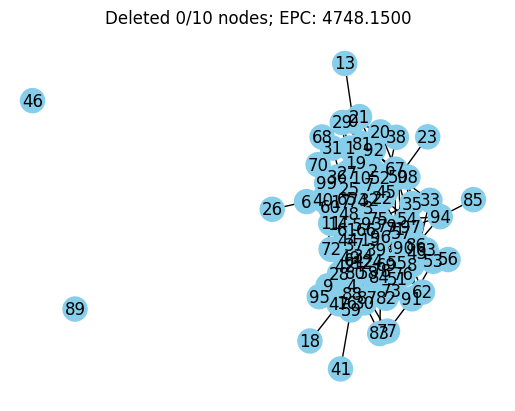

Deleted 0/10 nodes; current EPC: 4748.1500
Step  1: delete= 68, reward=57.9260, done=False


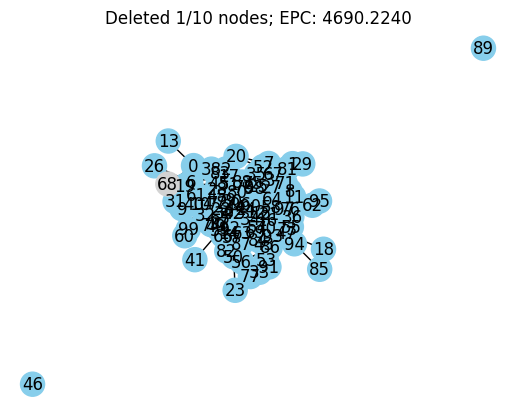

Deleted 1/10 nodes; current EPC: 4690.2240
Step  2: delete= 15, reward=114.3590, done=False


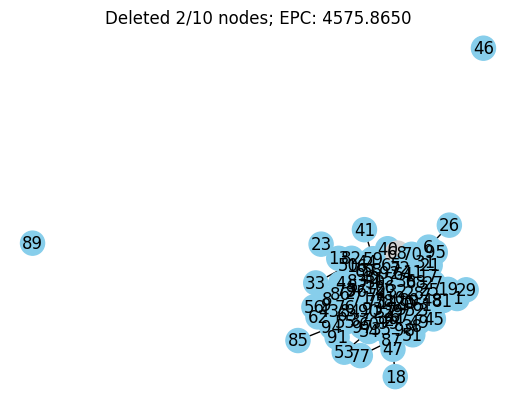

Deleted 2/10 nodes; current EPC: 4575.8650
Step  3: delete= 64, reward=187.1485, done=False


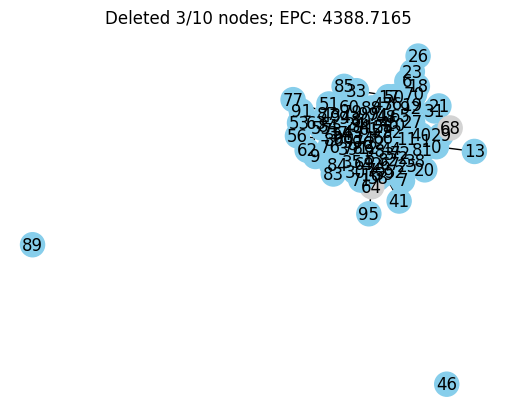

Deleted 3/10 nodes; current EPC: 4388.7165
Step  4: delete= 60, reward=78.7005, done=False


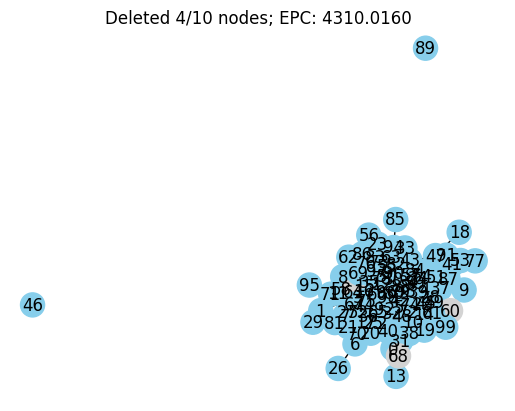

Deleted 4/10 nodes; current EPC: 4310.0160
Step  5: delete= 68, reward=-1.0000, done=False


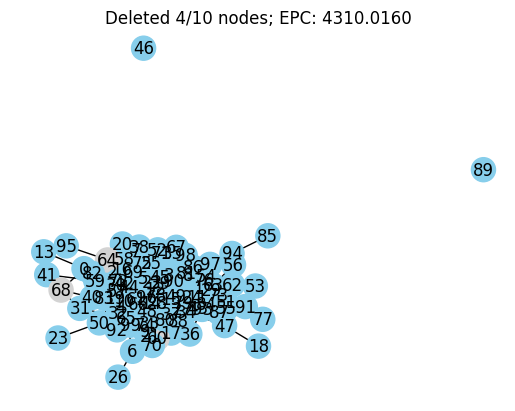

Deleted 4/10 nodes; current EPC: 4310.0160
Step  6: delete= 90, reward=99.9010, done=False


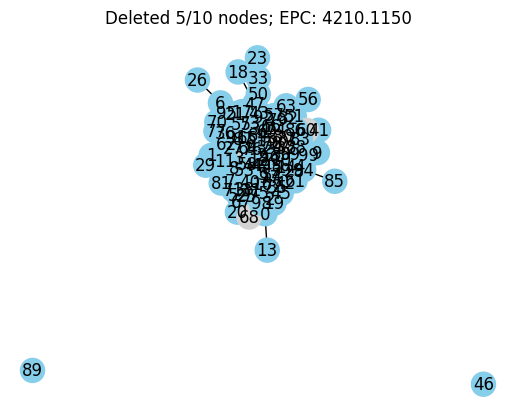

Deleted 5/10 nodes; current EPC: 4210.1150
Step  7: delete= 35, reward=111.2450, done=False


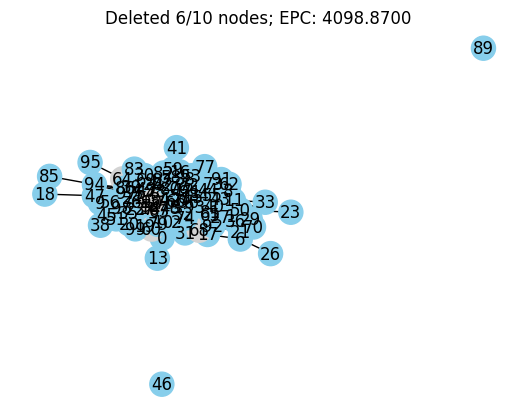

Deleted 6/10 nodes; current EPC: 4098.8700
Step  8: delete= 75, reward=138.3255, done=False


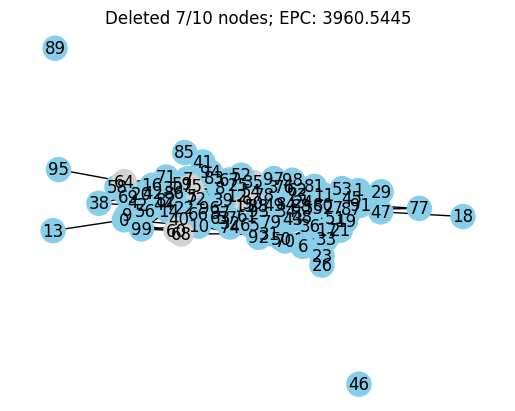

Deleted 7/10 nodes; current EPC: 3960.5445
Step  9: delete= 32, reward=54.2245, done=False


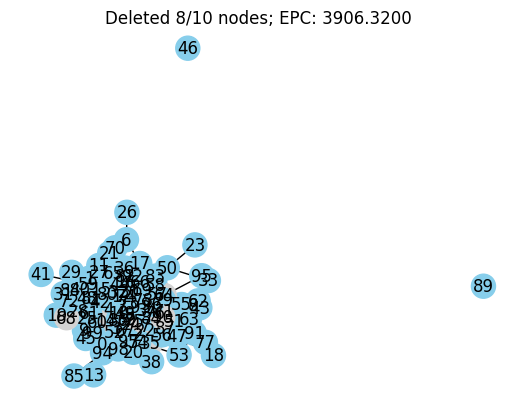

Deleted 8/10 nodes; current EPC: 3906.3200
Step 10: delete= 55, reward=94.2845, done=False


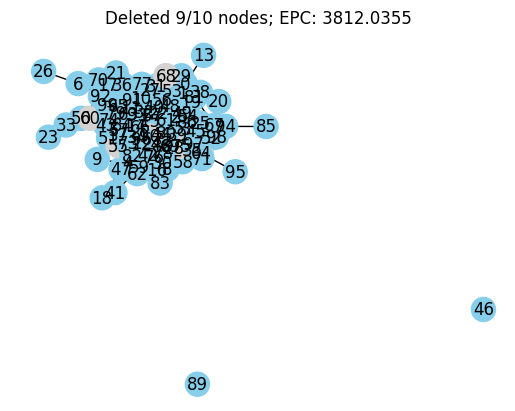

Deleted 9/10 nodes; current EPC: 3812.0355
Final EPC: 3812.0355


In [33]:
n, p = 100, 0.045
G = nx.erdos_renyi_graph(n, p, seed=42)
for u, v in G.edges():
    G[u][v]['p'] = 1.0

# 2. Instantiate env with K=5 deletions
K = 10
env = GraphDeletionEnv(G, K, model, component_sampling_epc_mc, num_samples=1000)

# 3. Reset & render initial state
obs = env.reset()
env.render()
time.sleep(1)

# 4. Take K random steps
for step in range(K):
    action = random.randrange(n)
    obs, reward, done, _ = env.step(action)
    print(f"Step {step+1:>2}: delete={action:>3}, reward={reward:.4f}, done={done}")
    env.render()
    time.sleep(1)
    if done:
        break

# 5. Final EPC check
print("Final EPC:", env.prev_epc)
plt.show(block=True)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self, num_nodes, embed_dim, hidden_dim):
        super().__init__()
        flat_dim = num_nodes * embed_dim

        # actor head: flattened embeddings → action logits
        self.actor = nn.Sequential(
            nn.Linear(flat_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_nodes)
        )
        # critic head: flattened embeddings → state-value
        self.critic = nn.Sequential(
            nn.Linear(flat_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, flat_emb: torch.Tensor):
        """
        flat_emb: [batch=1, flat_dim] tensor of floats
        returns: logits [1×num_nodes], value [scalar]
        """
        logits = self.actor(flat_emb)
        value  = self.critic(flat_emb).squeeze(-1)
        return logits, value


import torch
import torch.nn as nn
from torch.distributions import Categorical

class PPO:
    def __init__(self, model, lr=3e-4, gamma=0.99, eps_clip=0.2, K_epochs=4):
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        # rollout storage
        self.obs       = []   # list of flat tensors [1×flat_dim]
        self.actions   = []   # list of ints
        self.log_probs = []   # list of tensors [1]
        self.rewards   = []   # list of floats
        self.dones     = []   # list of bools

    def select_action(self, obs_flat):
        """
        obs_flat: a [1 x flat_dim] torch.Tensor
        """
        logits, value = self.model(obs_flat)
        dist   = Categorical(logits=logits)
        action = dist.sample()

        # store for later
        self.obs.append(obs_flat)
        self.actions.append(action)
        self.log_probs.append(dist.log_prob(action))
        self.dones.append(False)    # will fix last step
        return action.item(), value

    def record_reward(self, reward, done):
        self.rewards.append(reward)
        self.dones[-1] = done       # correct the last entry

    def update(self):
        # 1) compute discounted returns
        returns = []
        Gt = 0
        for r, done in zip(reversed(self.rewards), reversed(self.dones)):
            if done:
                Gt = 0
            Gt = r + self.gamma * Gt
            returns.insert(0, Gt)
        returns = torch.tensor(returns, dtype=torch.float).unsqueeze(1)  # [T,1]

        # 2) for K epochs, re-evaluate policy on stored obs
        for _ in range(self.K_epochs):
            new_log_probs = []
            values       = []
            for obs_flat in self.obs:
                logits, value = self.model(obs_flat)
                dist = Categorical(logits=logits)
                new_log_probs.append(dist.log_prob(self.actions[len(new_log_probs)]))
                values.append(value)
            new_log_probs = torch.stack(new_log_probs)    # [T]
            values        = torch.stack(values).unsqueeze(1)  # [T,1]
            old_log_probs = torch.stack(self.log_probs).unsqueeze(1)  # [T,1]

            # 3) compute advantages
            advantages = returns - values.detach()

            # 4) surrogate losses
            ratio = torch.exp(new_log_probs.unsqueeze(1) - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantages
            actor_loss  = -torch.min(surr1, surr2).mean()
            critic_loss = nn.MSELoss()(values, returns)
            loss = actor_loss + 0.5 * critic_loss

            # 5) gradient step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # 6) clear buffers
        self.obs.clear()
        self.actions.clear()
        self.log_probs.clear()
        self.rewards.clear()
        self.dones.clear()


In [44]:
import random

# hyperparams
K = 10
num_samples = 1000       # smaller MC for speed
hidden_dim = 256
max_episodes = 200

# build env & agent
G = nx.erdos_renyi_graph(100, 0.045, seed=42)
for u,v in G.edges():
  G[u][v]['p'] = 1.0

env = GraphDeletionEnv(G, K, gcn_model=model, epc_fn=component_sampling_epc_mc)
# model now takes *flat embeddings*, not Data
ppo_model = ActorCritic(
    num_nodes=env.orig_n,
    embed_dim=env.embed_dim,
    hidden_dim=256
)
ppo = PPO(ppo_model, lr=3e-4, gamma=0.99, eps_clip=0.2, K_epochs=4)

# training
for ep in range(max_episodes):
    # 1. Reset env and get initial obs as a NumPy array [num_nodes × embed_dim]
    obs = env.reset()

    total_reward = 0
    for t in range(env.K):
        # ────────────────────────────────────────────────────────────
        # NEW: convert obs → flat torch.Tensor before selecting action
        flat_obs = torch.from_numpy(obs).float().view(1, -1)  
        action, value = ppo.select_action(flat_obs)
        # ────────────────────────────────────────────────────────────

        # step the env
        next_obs, reward, done, _ = env.step(action)

        # store reward + done flag
        ppo.record_reward(reward, done)

        total_reward += reward
        obs = next_obs

        if done:
            break

    # After K steps, update PPO (this will re-run the policy on stored flats)
    ppo.update()
    print(f"Episode {ep+1} | Total Reward: {total_reward:.4f}")

    
    # after training, test a single rollout
    obs = env.reset()
    for _ in range(K):
      a = ppo.select_action(obs)
      obs, r, d, _ = env.step(a)
      env.render()
      if d: break

/home/tuguldurb/Development/Research/SCNDP/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.